In [1]:
import os
import pickle
import sys
sys.path.append('..')
from mtDNAsim import *

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from ete3 import Tree
from Bio import Phylo
from io import StringIO
import re
import seaborn as sns

In [3]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [4]:
from tqdm.notebook import tqdm

In [748]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.rcParams['font.size'] = 12
plt.rcParams['pdf.fonttype'] = 42

In [105]:
rf_data = pd.DataFrame()
path = '/data3/wangkun/mtsim_res/20240903/'
for model in os.listdir(path):
    if model == 'test':
        continue
    for simid in os.listdir(f'{path}/{model}'):
        try:
            rft = pd.read_csv(f'{path}/{model}/{simid}/rf_dist.txt', sep='\t')
            rf_data = pd.concat((rf_data, rft),ignore_index=True)
        except:
            pass

In [106]:
rf_data['seq'][rf_data['seq']!='_seq'] = 'no'

/tmp/ipykernel_89187/157854779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_data['seq'][rf_data['seq']!='_seq'] = 'no'


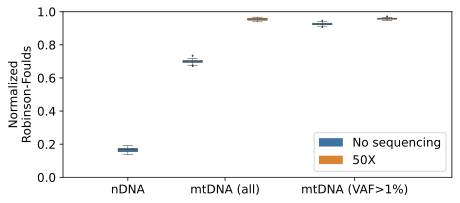

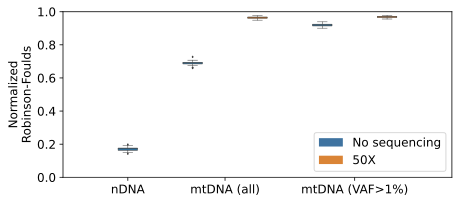

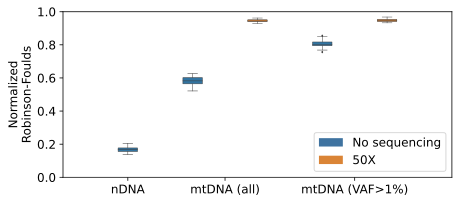

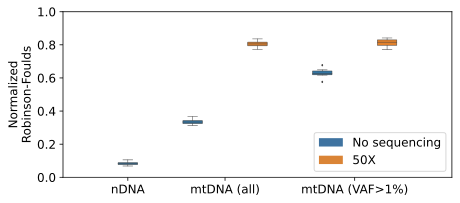

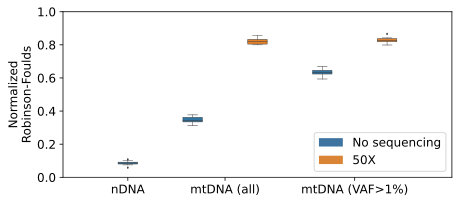

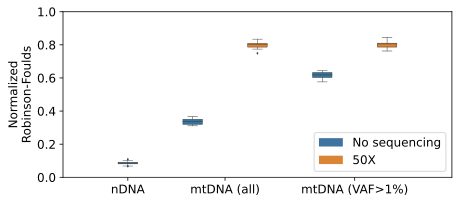

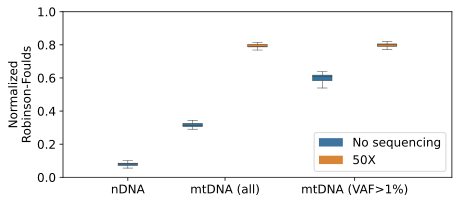

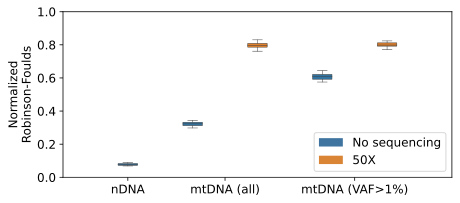

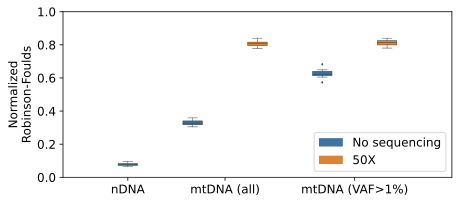

In [139]:
generation = 30
heterp = 10
for generation in [30, 130, 330]:
    for heterp in [0, 10, 100]:
        rf_tmp = rf_data[rf_data['model']==f'const_{heterp}']
        bp_dat = []

        rf_tmp_1 = rf_tmp[(rf_tmp['gen']==generation)&(rf_tmp['type']=='nDNA')]
        bp_dat.append(np.array(rf_tmp_1['rf']/rf_tmp_1['maxrf']).flatten())

        for cutoff in [0, 0.01]:
            for seq in ['no', '_seq']:
                rf_tmp_1 = rf_tmp[(rf_tmp['seq']==seq)&(rf_tmp['gen']==generation)&(rf_tmp['type']=='mtDNA')&(rf_tmp['cutoff']==cutoff)]
                bp_dat.append(np.array(rf_tmp_1['rf']/rf_tmp_1['maxrf']).flatten())


        colors=sns.color_palette(['tab:blue','tab:blue','tab:orange','tab:blue','tab:orange'])
        fig, ax = plt.subplots(figsize=(7,3))
        ax = sns.boxplot(bp_dat, ax=ax, width=0.3, palette=colors, linewidth=0.5, fliersize=1)
        ax.set_ylabel('Normalized\nRobinson-Foulds')

        ax.set_xlim((-1,5))

        legend_elements = []

        legend_elements.append(Patch(facecolor='#3f73a0',label='No sequencing'))
        legend_elements.append(Patch(facecolor='#da8436',label='50X'))
        ax.legend(handles=legend_elements, loc=4)
        ax.set_xticks([0, 1.5, 3.5], ['nDNA', 'mtDNA (all)', 'mtDNA (VAF>1%)'])
        # ax.set_title(f'Root cell heteroplasmy={heterp}')
        ax.set_ylim((0, 1))
        plt.savefig(f'../figs/rf_boxplot_{generation}_{heterp}.pdf')

  0%|          | 0/9326 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:788: RuntimeWarning: invalid value encountered in divide
  freq_samp = read_cnt/depth


  0%|          | 0/1141 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:788: RuntimeWarning: invalid value encountered in divide
  freq_samp = read_cnt/depth


  0%|          | 0/1020 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:788: RuntimeWarning: invalid value encountered in divide
  freq_samp = read_cnt/depth


  0%|          | 0/9023 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:788: RuntimeWarning: invalid value encountered in divide
  freq_samp = read_cnt/depth


  0%|          | 0/919 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:788: RuntimeWarning: invalid value encountered in divide
  freq_samp = read_cnt/depth


  0%|          | 0/934 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:788: RuntimeWarning: invalid value encountered in divide
  freq_samp = read_cnt/depth


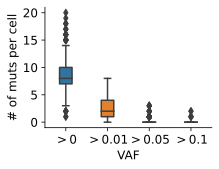

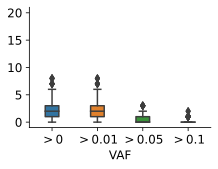

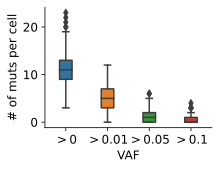

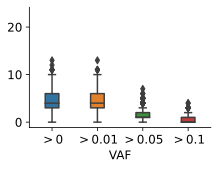

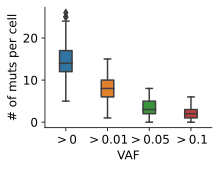

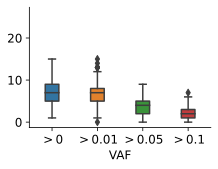

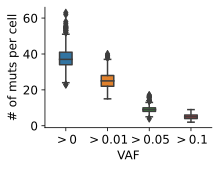

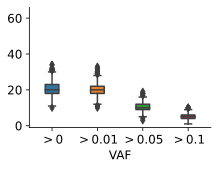

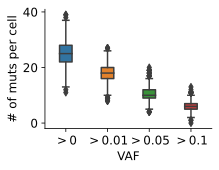

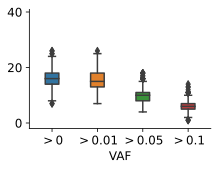

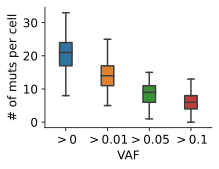

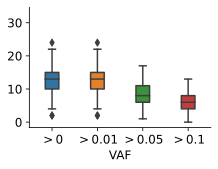

In [172]:
for path in ['/data3/wangkun/mtsim_res/20240903/const_10/714932/',
             '/data3/wangkun/mtsim_res/20240903/const_100/11506/']:
    heterp = path.split('const_')[1].split('/')[0]
    for gen in [30, 130, 330]:
        mts = pickle.load(open(f'{path}mt_allmuts_{gen}.pkl', 'rb'))
        mt_freq = sparse_freq(mts)
        if gen == 30:
            tree = Phylo.read(f'{path}/gt_tree.nwk', 'newick')
            sel_cells = [i.name for i in tree.get_terminals()]
            mt_freq = mt_freq.loc[sel_cells]

        mt_freq_samp = sequence_sim(mt_freq, 50, n=2.5)

        num_vaf = []
        for i in [0,0.01,0.05,0.1]:
            num_vaf.append(np.sum(mt_freq>i, axis=1).to_numpy())
            
        fig, ax = plt.subplots(figsize=(3.2, 2.5))
        # fig, ax = plt.subplots(1, 2, figsize=(7.2, 3.6))
        sns.boxplot(num_vaf, width=0.3, ax=ax)
        ax.set_xticklabels(['$>0$', '$>0.01$', '$>0.05$', '$>0.1$'])
        ax.set_ylabel('# of muts per cell')
        ax.set_xlabel('VAF')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ylim = ax.get_ylim()
        plt.tight_layout()
        plt.savefig(f'../figs/vaf_{gen}_heterp{heterp}_ns.pdf')
        
        num_vaf = []
        for i in [0,0.01,0.05,0.1]:
            num_vaf.append(np.sum(mt_freq_samp>i, axis=1).to_numpy())
        fig, ax = plt.subplots(figsize=(3.2, 2.5))
        sns.boxplot(num_vaf, width=0.3, ax=ax)
        ax.set_xticklabels(['$>0$', '$>0.01$', '$>0.05$', '$>0.1$'])
        ax.set_xlabel('VAF')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylim(ylim)
        plt.tight_layout()
        plt.savefig(f'../figs/vaf_{gen}_heterp{heterp}_s.pdf')

  0%|          | 0/9023 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:788: RuntimeWarning: invalid value encountered in divide
  freq_samp = read_cnt/depth


  0%|          | 0/919 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:788: RuntimeWarning: invalid value encountered in divide
  freq_samp = read_cnt/depth


  0%|          | 0/934 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:788: RuntimeWarning: invalid value encountered in divide
  freq_samp = read_cnt/depth


  0%|          | 0/9137 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:788: RuntimeWarning: invalid value encountered in divide
  freq_samp = read_cnt/depth


  0%|          | 0/1009 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:788: RuntimeWarning: invalid value encountered in divide
  freq_samp = read_cnt/depth


  0%|          | 0/1098 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:788: RuntimeWarning: invalid value encountered in divide
  freq_samp = read_cnt/depth


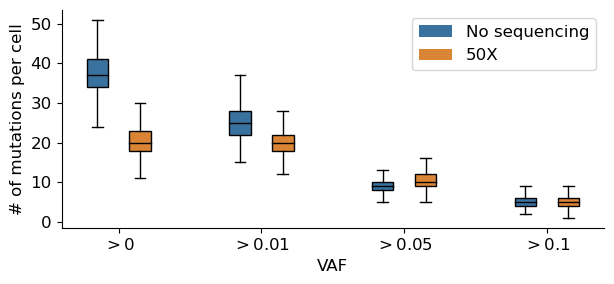

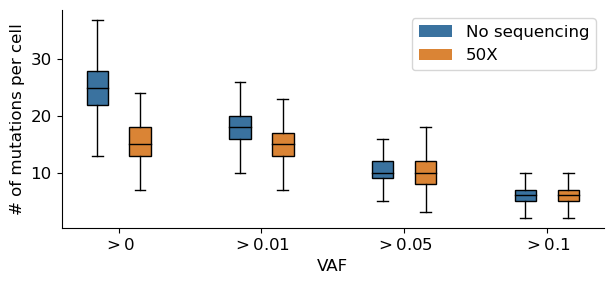

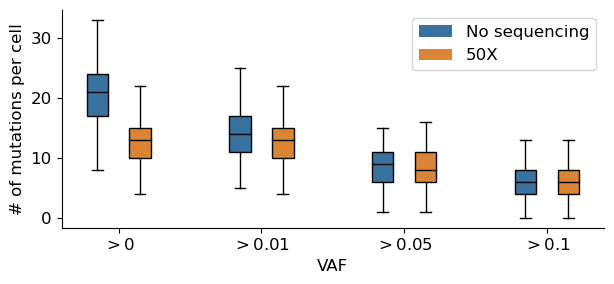

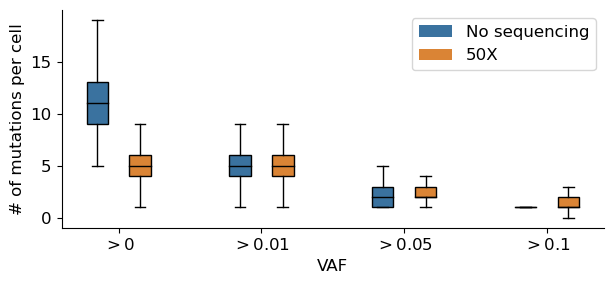

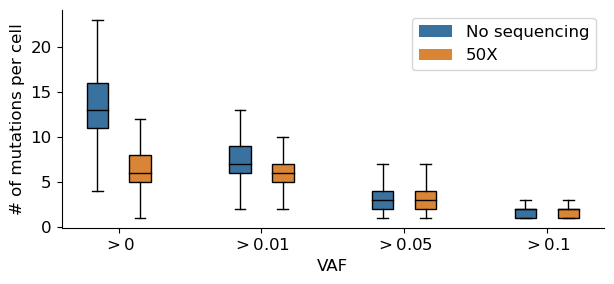

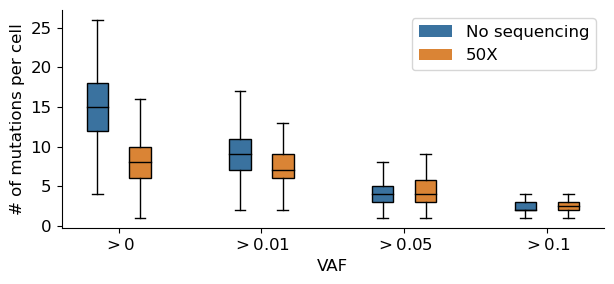

In [1104]:
# path = '/data3/wangkun/mtsim_res/20240903/const_100/292066/'
path =  '/data3/wangkun/mtsim_res/20240903/const_10/243093/'
for path in ['/data3/wangkun/mtsim_res/20240903/const_100/11506/', '/data3/wangkun/mtsim_res/20240903/const_10/243093/']:
    if '_100' in path:
        hp = 100
    else:
        hp = 10
    for gen in [30, 130, 330]:
        mts = pickle.load(open(f'{path}mt_allmuts_{gen}.pkl', 'rb'))
        mt_freq = sparse_freq(mts)
        if gen == 30:
            tree = Phylo.read(f'{path}/gt_tree.nwk', 'newick')
            sel_cells = [i.name for i in tree.get_terminals()]
            mt_freq = mt_freq.loc[sel_cells]

        mt_freq_samp = sequence_sim(mt_freq, 50, n=2.5)

        num_vaf = []
        for i in [0,0.01,0.05,0.1]:
            for freq_i in (mt_freq, mt_freq_samp):
                num_vaf.append(np.sum(freq_i>i, axis=1).to_numpy())
        fig, ax = plt.subplots(1, 1, figsize=(6.3, 3))
        medianprops = dict(color='black')
        bp = ax.boxplot(num_vaf, positions=[0.2,0.8, 2.2,2.8,4.2,4.8,6.2,6.8],
                        widths=0.3, patch_artist=True, medianprops=medianprops,showfliers=False)
        ax.set_xlabel('VAF')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        colors=['#3a729f','#da8435','#3a729f','#da8435','#3a729f','#da8435','#3a729f','#da8435']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        ax.set_ylabel('# of mutations per cell')
        legend_elements = []
        legend_elements.append(Patch(facecolor='#3a729f',label='No sequencing'))
        legend_elements.append(Patch(facecolor='#da8435',label='50X'))
        ax.legend(handles=legend_elements, loc=1)
        ax.set_xticks([0.5, 2.5, 4.5, 6.5], 
                      ['$>0$', '$>0.01$', '$>0.05$', '$>0.1$'])
        plt.tight_layout()
        plt.savefig(f'../figs/vaf_{gen}_heterp{hp}.pdf')

In [1100]:
# path = '/data3/wangkun/mtsim_res/20240903/const_100/292066'
path =  '/data3/wangkun/mtsim_res/20240903/const_10/243093'
for path in ['/data3/wangkun/mtsim_res/20240903/const_10/243093', '/data3/wangkun/mtsim_res/20240903/const_100/34468']:
    for gen in ['_30', '_130', '_330']:
        treegt = Phylo.read(f'{path}/gt_tree{gen}.nwk'.replace('_30', ''), 'newick')
        if gen == '_30':
            for i in treegt.get_terminals():
                for j in treegt.get_path(i)[::-1][1:]:
                    if len(j.clades) == 1:
                        treegt.collapse(j)
            Phylo.write(treegt, f'{path}/gt_tree{gen}.nwk','newick')
        clones = list(set([i.name.split('>')[0]+'>' for i in treegt.get_terminals()]))
        # colors = ['#5D8AA8','#E32636','#FFBF00','#A4C639','#FBCEB1','#7FFFD4','#4B5320','#3B444B','#E9D66B','#B2BEB5','#FF9966','#6D351A','#007FFF','#89CFF0','#98777B','#DE5D83','#66FF00','#BF94E4','#FF007F','#004225','#FFC1CC','#800020']
        colors=['#84CF96','#C6E7CE','#AFE6A0','#A5BFFA','#D6D0FA','#FAAC9B','#C675B6','#FFC33C','#FBE2B4','#5BC2BA','#670755','#C151B8','#724094','#FC6621','#CC2A27','#7475E6','#00992C','#2040BD','#8F4851','#670755']
        header = ['DATASET_COLORSTRIP','SEPARATOR SPACE','DATASET_LABEL label1','COLOR #ff0000','STRIP_WIDTH 120', 'DATA']
        # header = []
        if len(clones) <= 20:
            color_tab = dict(zip(clones, colors[:len(clones)]))
            with open(f'{path}/tree_color{gen}.txt', 'w') as f:
                f.write('\n'.join(header))
                f.write('\n')
                for i in treegt.get_terminals():
                    f.write(f"{i.name} {color_tab[i.name.split('>')[0]+'>']}\n")
        else:
            progenitors = [treegt.root]
            iters = 0
            while len(progenitors)<20:
                iters += 1
                if iters > 100:
                    print('unsuccess')
                    break
                try:
                    progenitors.append(progenitors[0].clades[0])
                    progenitors.append(progenitors[0].clades[1])
                except:
                    pass
                progenitors.pop(0)

            with open(f'{path}/tree_color{gen}.txt', 'w') as f:
                f.write('\n'.join(header))
                f.write('\n')
                for ind, i in enumerate(progenitors):
                    for j in i.get_terminals():
                        f.write(f'{j.name} {colors[ind]}\n')


In [95]:
path = '/data3/wangkun/mtsim_res/20240903/const_10/714932/'
treegt = Phylo.read(f'{path}/gt_tree_330.nwk', 'newick')
mt30 = pickle.load(open(f'{path}mt_allmuts_330.pkl', 'rb'))

In [96]:
freq = sparse_freq(mt30).loc[[i.name for i in treegt.get_terminals()]]
freq_seq = sequence_sim(freq, 20, n=2.5)

  0%|          | 0/1020 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:788: RuntimeWarning: invalid value encountered in divide
  freq_samp = read_cnt/depth


In [97]:
for cutoff in [0, 0.01]:
    muts = freq_seq>cutoff
    muts = muts.iloc[:, np.where(muts.sum(0)>0)[0]]
    muts = muts.astype(int).astype(str)
    translation_table = str.maketrans({'1': 'A', '0': 'G'})
    seqs = f'{muts.shape[0]} {muts.shape[1]}\n'
    for i in range(muts.shape[0]):
        seqs += f'{muts.index[i]} '
        seqs += ''.join(muts.iloc[i].to_numpy()).translate(translation_table)
        seqs += '\n'
    with open(f'{path}/mt_allmuts_330_{cutoff}_seq_20x.phy', 'w') as f:
        f.write(seqs)

In [98]:
def robinson_foulds(tree1:'Bio.Phylo.BaseTree', tree2:'Bio.Phylo.BaseTree'):
    f = StringIO()
    Phylo.write(tree1, f, 'newick')
    tree1 = Tree(f.getvalue(), format=1)
    # tree1.prune(tree1.get_leaf_names())
    f = StringIO()
    Phylo.write(tree2, f, 'newick')
    tree2 = Tree(f.getvalue(), format=1)
    # tree2.prune(tree2.get_leaf_names())
    try:
        return tree1.robinson_foulds(tree2)
    except:
        return tree1.robinson_foulds(tree2, unrooted_trees=True)

In [797]:
for path in ['/data3/wangkun/mtsim_res/20240903/const_10/243093/', '/data3/wangkun/mtsim_res/20240903/const_100/112603/']:
    for gen in [30, 130, 330]:
        treegt = Phylo.read(f'{path}/gt_tree_{gen}.nwk', 'newick')
        tree_ns = Phylo.read(f'{path}/mt_allmuts_{gen}_0.phy_nj.nwk', 'newick')
        tree_50x = Phylo.read(f'{path}/mt_allmuts_{gen}_0_seq.phy_nj.nwk', 'newick')
        tree_ns1 = Phylo.read(f'{path}/mt_allmuts_{gen}_0.01.phy_nj.nwk', 'newick')
        tree_50x1 = Phylo.read(f'{path}/mt_allmuts_{gen}_0.01_seq.phy_nj.nwk', 'newick')
        rf30_ns = robinson_foulds(treegt, tree_ns)
        rf30_50x = robinson_foulds(treegt, tree_50x)
        rf30_ns1 = robinson_foulds(treegt, tree_ns1)
        rf30_50x1 = robinson_foulds(treegt, tree_50x1)
        print(gen)
        print(rf30_ns[0]/rf30_ns[1])
        print(rf30_ns1[0]/rf30_ns1[1])
        print(rf30_50x[0]/rf30_50x[1])
        print(rf30_50x1[0]/rf30_50x1[1])

30
0.6860581745235708
0.9237713139418254
0.9638916750250752
0.9679037111334002
130
0.3121272365805169
0.6262425447316103
0.8041749502982107
0.820079522862823
330
0.3324200913242009
0.6191780821917808
0.8301369863013699
0.8237442922374429
30
0.5807422266800402
0.8104312938816449
0.9458375125376128
0.9448345035105316
130
0.313915857605178
0.5760517799352751
0.7486515641855448
0.7626752966558792
330
0.3096646942800789
0.6479289940828402
0.8106508875739645
0.8057199211045365


In [226]:
subtree_gt = treegt.common_ancestor([i for i in treegt.get_terminals() if '34_3317' in i.name])
progenitors = [subtree_gt.root]
iters = 0
while len(progenitors)<16:
    iters += 1
    if iters > 100:
        print('unsuccess')
        break
    try:
        progenitors.append(progenitors[0].clades[0])
        progenitors.append(progenitors[0].clades[1])
    except:
        pass
    progenitors.pop(0)

with open(f'{path}/tree_color_subtree.txt', 'w') as f:
    f.write('\n'.join(header))
    f.write('\n')
    for ind, i in enumerate(progenitors):
        for j in i.get_terminals():
            f.write(f'{j.name} {colors[ind]}\n')


In [544]:
def get_gt_dist(tree_mt, tree_gt, niter=100):
    pairs = []
    cnt = 0
    all_cells = tree_mt.get_terminals()
    for i in tree_mt.get_terminals():
        i.branch_length=1
    for i in tree_mt.get_nonterminals():
        i.branch_length=1
    with tqdm(total=niter) as pbar:
        while cnt < niter:
            c1 = all_cells[np.random.choice(range(len(all_cells)))]
            for anc in tree_mt.get_path(c1)[::-1][1:]:
                if len(anc.get_terminals())<2:
                    continue
                siss, dists = [], []
                for sis in anc.get_terminals():
                    siss.append(sis)
                    dists.append(tree_mt.distance(c1, sis))

                c2 = siss[np.where(np.argsort(dists)==len(dists)-1)[0][0]]
                pairs.append((c1.name, c2.name))
                cnt += 1
                pbar.update(1)
                break
            
    dist_gt = []
    for i in pairs:
        c1, c2 = tree_gt.find_any(i[0]), tree_gt.find_any(i[1])
        dist_gt.append(tree_gt.distance(c1, c2))
    return np.array(dist_gt)/2

In [954]:
path = '/data3/wangkun/mtsim_res/20240903/const_10/243093/'
tree_gt = Phylo.read(f'{path}/gt_tree.nwk', 'newick')
tree_mt = Phylo.read(f'{path}/mt_allmuts_30_0.phy_nj.nwk', 'newick')
tree_ndna = Phylo.read(f'{path}/dna_mut.phy_nj.nwk', 'newick')
tree_mt1 = Phylo.read(f'{path}/mt_allmuts_30_0.01.phy_nj.nwk', 'newick')
tree_mt_seq = Phylo.read(f'{path}/mt_allmuts_30_0_seq.phy_nj.nwk', 'newick')
tree_mt1_seq = Phylo.read(f'{path}/mt_allmuts_30_0.01_seq.phy_nj.nwk', 'newick')

niter = 500
dist_mt10 = get_gt_dist(tree_mt, tree_gt, niter=niter)
dist_ndna10 = get_gt_dist(tree_ndna, tree_gt, niter=niter)
dist_mt110 = get_gt_dist(tree_mt1, tree_gt, niter=niter)
dist_mt_seq10 = get_gt_dist(tree_mt_seq, tree_gt, niter=niter)
dist_mt1_seq10 = get_gt_dist(tree_mt1_seq, tree_gt, niter=niter)
dist_gt10 = get_gt_dist(tree_gt, tree_gt, niter=niter)
dist_random10 = []
cells_gt = tree_gt.get_terminals()
for _ in range(niter):
    c1, c2 = np.random.choice(range(len(cells_gt)), 2, replace=False)
    dist_random10.append(tree_gt.distance(cells_gt[c1], cells_gt[c2])/2)

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [553]:
path = '/data3/wangkun/mtsim_res/20240903/const_100/292066/'
tree_gt = Phylo.read(f'{path}/gt_tree.nwk', 'newick')
tree_mt = Phylo.read(f'{path}/mt_allmuts_30_0.phy_nj.nwk', 'newick')
tree_ndna = Phylo.read(f'{path}/dna_mut.phy_nj.nwk', 'newick')
tree_mt1 = Phylo.read(f'{path}/mt_allmuts_30_0.01.phy_nj.nwk', 'newick')
tree_mt_seq = Phylo.read(f'{path}/mt_allmuts_30_0_seq.phy_nj.nwk', 'newick')
tree_mt1_seq = Phylo.read(f'{path}/mt_allmuts_30_0.01_seq.phy_nj.nwk', 'newick')

niter = 500
dist_mt100 = get_gt_dist(tree_mt, tree_gt, niter=niter)
dist_ndna100 = get_gt_dist(tree_ndna, tree_gt, niter=niter)
dist_mt1100 = get_gt_dist(tree_mt1, tree_gt, niter=niter)
dist_mt_seq100 = get_gt_dist(tree_mt_seq, tree_gt, niter=niter)
dist_mt1_seq100 = get_gt_dist(tree_mt1_seq, tree_gt, niter=niter)
dist_gt100 = get_gt_dist(tree_gt, tree_gt, niter=niter)
dist_random100 = []
cells_gt = tree_gt.get_terminals()
for _ in range(niter):
    c1, c2 = np.random.choice(range(len(cells_gt)), 2, replace=False)
    dist_random100.append(tree_gt.distance(cells_gt[c1], cells_gt[c2])/2)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Root cell heteroplasmy = 10')

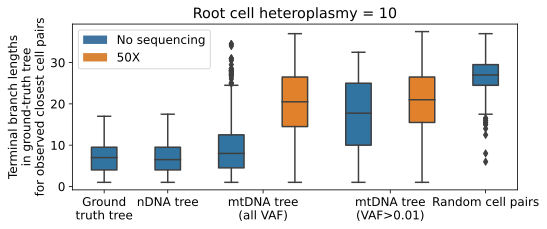

In [576]:
fig, ax = plt.subplots(figsize=(8,3))
colors=sns.color_palette(['tab:blue','tab:blue','tab:blue','tab:orange','tab:blue','tab:orange'])

sns.boxplot([dist_gt10, dist_ndna10, dist_mt10, dist_mt_seq10, dist_mt110, dist_mt1_seq10, dist_random10], 
            width=0.4, palette=colors)
legend_elements = []
legend_elements.append(Patch(facecolor='#3f73a0',label='No sequencing'))
legend_elements.append(Patch(facecolor='#da8436',label='50X'))
ax.legend(handles=legend_elements, loc=2)
ax.set_xticks([0,1,2.5, 4.5, 6], 
              ['Ground\ntruth tree','nDNA tree','mtDNA tree\n(all VAF)', 'mtDNA tree\n(VAF>0.01)', 'Random cell pairs'])
ax.set_ylabel('Terminal branch lengths\nin ground-truth tree\nfor observed closest cell pairs')
ax.set_title('Root cell heteroplasmy = 10')

Text(0.5, 1.0, 'Root cell heteroplasmy = 100')

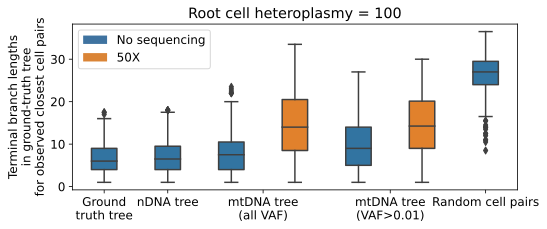

In [579]:
fig, ax = plt.subplots(figsize=(8,3))
colors=sns.color_palette(['tab:blue','tab:blue','tab:blue','tab:orange','tab:blue','tab:orange'])

sns.boxplot([dist_gt100, dist_ndna100, dist_mt100, dist_mt_seq100, dist_mt1100, dist_mt1_seq100, dist_random100], 
            width=0.4, palette=colors)
legend_elements = []
legend_elements.append(Patch(facecolor='#3f73a0',label='No sequencing'))
legend_elements.append(Patch(facecolor='#da8436',label='50X'))
ax.legend(handles=legend_elements, loc=2)
ax.set_xticks([0,1,2.5, 4.5, 6], 
              ['Ground\ntruth tree','nDNA tree','mtDNA tree\n(all VAF)', 'mtDNA tree\n(VAF>0.01)', 'Random cell pairs'])
ax.set_ylabel('Terminal branch lengths\nin ground-truth tree\nfor observed closest cell pairs')
ax.set_title('Root cell heteroplasmy = 100')

In [284]:
mt30 = pickle.load(open(f'{path}/mt_allmuts_30.pkl', 'rb'))
mt130 = pickle.load(open(f'{path}/mt_allmuts_130.pkl', 'rb'))
mt330 = pickle.load(open(f'{path}/mt_allmuts_330.pkl', 'rb'))

In [343]:
freq_30 = sparse_freq(mt30).loc[[i.name for i in tree_gt.get_terminals()]]
freq_130 = sparse_freq(mt130)
freq_330 = sparse_freq(mt330)

  0%|          | 0/9326 [00:00<?, ?it/s]

  0%|          | 0/1141 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

In [344]:
cnt_30 = Counter([i.split('>')[0] for i in freq_30.index])
cnt_130 = Counter([i.split('>')[0] for i in freq_130.index])
cnt_330 = Counter([i.split('>')[0] for i in freq_330.index])

In [363]:
muller_data = []
for i in np.random.choice(freq_30.index, 20, replace=False):
    i = i[:-1]
    data_i = [1]
    if i in cnt_330:
        data_i.append(cnt_130[i])
        data_i.append(cnt_330[i])
    else:
        
        if i in cnt_130:
            data_i.append(cnt_130[i])
            data_i.append(0)
        else:
            data_i.append(0)
            data_i.append(0)
    
    muller_data.append(data_i)

In [364]:
pd.DataFrame(muller_data).to_csv('/data3/wangkun/mtsim_res/20240903/test/muller_20.csv')

In [626]:
# path = '/data3/wangkun/mtsim_res/20240903/const_100/112603'
path =  '/data3/wangkun/mtsim_res/20240903/const_10/243093'
tree_gt = Phylo.read(f'{path}/gt_tree_30.nwk', 'newick')
tree_mt = Phylo.read(f'{path}/mt_allmuts_30_0.phy_nj.nwk', 'newick')
tree_ndna = Phylo.read(f'{path}/dna_mut.phy_nj.nwk', 'newick')
tree_mt1 = Phylo.read(f'{path}/mt_allmuts_30_0.01.phy_nj.nwk', 'newick')
tree_mt_seq = Phylo.read(f'{path}/mt_allmuts_30_0_seq.phy_nj.nwk', 'newick')
tree_mt1_seq = Phylo.read(f'{path}/mt_allmuts_30_0.01_seq.phy_nj.nwk', 'newick')


In [912]:
from collections import defaultdict
def write_rf_colors(tree_gt, tree_mt, output):
    betas_gt = []
    for i in tree_gt.get_nonterminals():
        betas_gt.append([j.name for j in i.get_terminals()])
    mt_color = defaultdict(float)
    for i in tree_mt.get_nonterminals():
        terminals_tmp = [j.name for j in i.get_terminals()]
        if not terminals_tmp in betas_gt:
            for j in terminals_tmp:
                mt_color[j] =  max(mt_color[j], 0)
        else:
            for j in terminals_tmp:
                mt_color[j] =  1
    header = ['DATASET_COLORSTRIP','SEPARATOR SPACE','DATASET_LABEL label1','COLOR #ff0000','STRIP_WIDTH 120', 'DATA']            
    color_tab = ['#b0221d', '#649f7f']
    'ffc1c6'
    '8ae8c7'
    with open(output, 'w') as f:
        f.write('\n'.join(header))
        f.write('\n')
        for i in mt_color:
            f.write(f'{i} {color_tab[int(mt_color[i])]}\n')
    return None 

In [913]:
# path = '/data3/wangkun/mtsim_res/20240903/const_100/292066'
path =  '/data3/wangkun/mtsim_res/20240903/const_10/243093'
for i in [i for i in os.listdir(path) if 'nwk' in i]:
    if '_30' in i:
        tree_gt = Phylo.read(f'{path}/gt_tree_30.nwk', 'newick')
    elif '_130' in i:
        tree_gt = Phylo.read(f'{path}/gt_tree_130.nwk', 'newick')
    else:
        tree_gt = Phylo.read(f'{path}/gt_tree_330.nwk', 'newick')
    tree_mt = Phylo.read(f'{path}/{i}', 'newick')
    write_rf_colors(tree_gt, tree_mt, f'{path}/rf_color_{i}.txt')

In [914]:
path = '/data3/wangkun/mtsim_res/20240903/const_100/292066'
# path =  '/data3/wangkun/mtsim_res/20240903/const_10/243093'
for i in [i for i in os.listdir(path) if 'nwk' in i]:
    if '_30' in i:
        tree_gt = Phylo.read(f'{path}/gt_tree_30.nwk', 'newick')
    elif '_130' in i:
        tree_gt = Phylo.read(f'{path}/gt_tree_130.nwk', 'newick')
    else:
        tree_gt = Phylo.read(f'{path}/gt_tree_330.nwk', 'newick')
    tree_mt = Phylo.read(f'{path}/{i}', 'newick')
    write_rf_colors(tree_gt, tree_mt, f'{path}/rf_color_{i}.txt')

In [785]:
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

/home/wangkun/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailabl

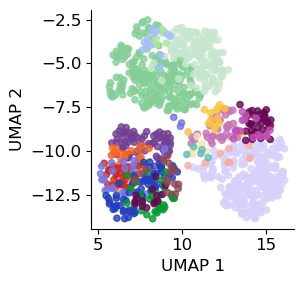

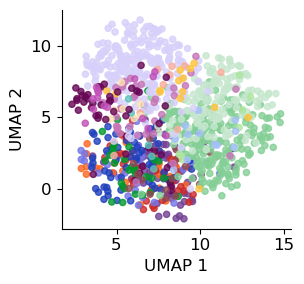

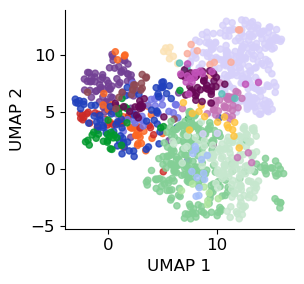

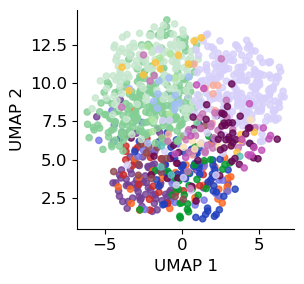

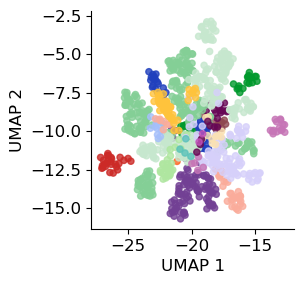

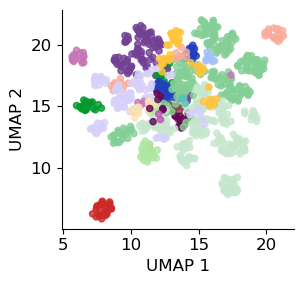

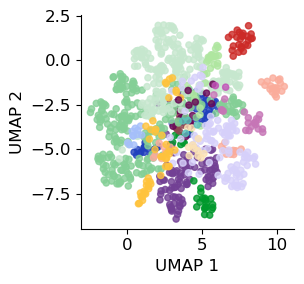

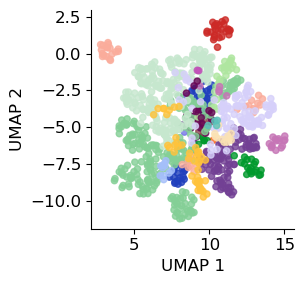

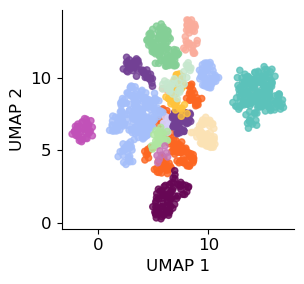

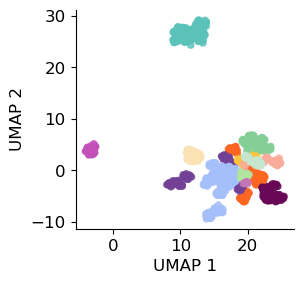

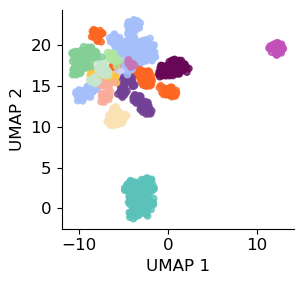

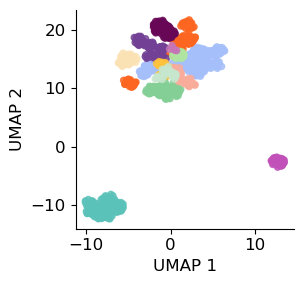

In [1101]:
path = '/data3/wangkun/mtsim_res/20240903/const_100/34468'
# path =  '/data3/wangkun/mtsim_res/20240903/const_10/243093'
for file in [i for i in os.listdir(path) if i[-3:] =='phy']:
    if 'dna' in file:
        continue
    if '_30' in file:
        color_file = 'tree_color_30.txt'
    elif '_130' in file:
        color_file = 'tree_color_130.txt'
    else:
        color_file = 'tree_color_330.txt'
    with open(f'{path}/{color_file}', 'r') as f:
        colors = f.readlines()
    color_dict = dict()
    for i in colors[6:]:
        cell, col = i.split(' ')
        color_dict[cell] = col.strip()
    
    with open(f'{path}/{file}', 'r') as f:
        seqs = f.readlines()
    seqs = seqs[1:]
    translation_table = str.maketrans({'A': '1', 'G': '0'})
    muttab = []
    cell_names = []
    for i in seqs:
        muttab.append(list(i.translate(translation_table).split(' ')[1].strip()))
        cell_names.append(i.split(' ')[0])
    mutdf = pd.DataFrame(np.array(muttab).astype(int), index=cell_names)
    # X_pc100 = PCA(n_components=100).fit_transform(mutdf)
    if ('_30' in file) and (file != 'mt_allmuts_30_0.phy'):
        mut_umap = umap.UMAP(n_components=2, min_dist=1, n_neighbors=5, metric='hamming').fit_transform(mutdf)
    else:
        mut_umap = umap.UMAP(n_components=2, min_dist=1, n_neighbors=100, metric='hamming').fit_transform(mutdf)
    # mut_umap = TSNE(n_components=2, perplexity=500).fit_transform(mutdf)
    fig, ax = plt.subplots(1, 1, figsize=(3.2,3))
    scat_color = []
    for i in mutdf.index:
        try:
            scat_color.append(color_dict[i])
        except:
            scat_color.append('#FFFFFF')
    ax.scatter(mut_umap[:,0], mut_umap[:,1], s=20, alpha=0.8,c=scat_color)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    plt.tight_layout()
    if '_100' in path:
        plt.savefig(f'../figs/umap_100/{file}.pdf')
    else:
        plt.savefig(f'../figs/umap_10/{file}.pdf')

In [1083]:
file

'mt_allmuts_130_0.phy'

In [957]:
for file in [i for i in os.listdir(path) if i[-3:] =='phy']:
    if 'dna' in file:
        continue
    if '_30' in file:
        continue
    elif '_130' in file:
        color_file = 'tree_color_130.txt'
    else:
        continue
        
    with open(f'{path}/{color_file}', 'r') as f:
        colors = f.readlines()
    color_dict = dict()
    for i in colors[6:]:
        cell, col = i.split(' ')
        color_dict[cell] = col.strip()
    
    with open(f'{path}/{file}', 'r') as f:
        seqs = f.readlines()
    seqs = seqs[1:]
    translation_table = str.maketrans({'A': '1', 'G': '0'})
    muttab = []
    cell_names = []
    for i in seqs:
        muttab.append(list(i.translate(translation_table).split(' ')[1].strip()))
        cell_names.append(i.split(' ')[0])
    mutdf = pd.DataFrame(np.array(muttab).astype(int), index=cell_names)
    break

In [990]:
file

'mt_allmuts_130_0.phy'

In [959]:
scat_color = []
for i in mutdf.index:
    try:
        scat_color.append(color_dict[i])
    except:
        scat_color.append('#FFFFFF')

/home/wangkun/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


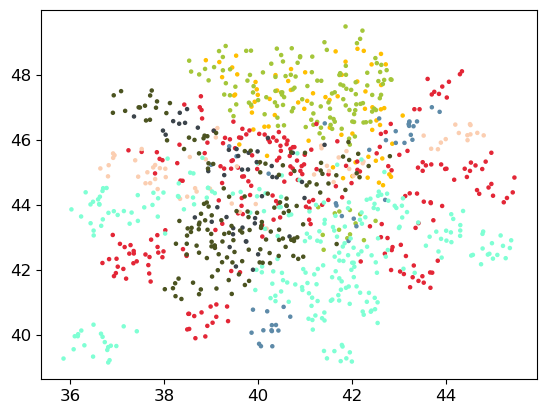

In [1085]:
mut_umap = umap.UMAP(n_components=2, min_dist=1, n_neighbors=100, metric='hamming').fit_transform(mutdf.to_numpy())
plt.scatter(mut_umap[:,0], mut_umap[:,1], s=5,c=scat_color)

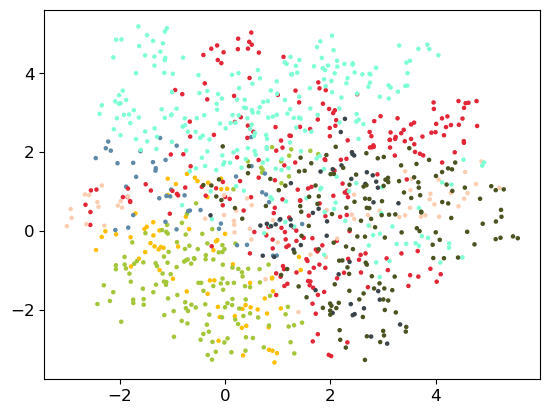

In [1080]:
mut_umap = umap.UMAP(n_components=2, min_dist=1, n_neighbors=200).fit_transform(mutdf.to_numpy())
plt.scatter(mut_umap[:,0], mut_umap[:,1], s=5,c=scat_color)

Text(0.5, 1.0, '50X All VAF')

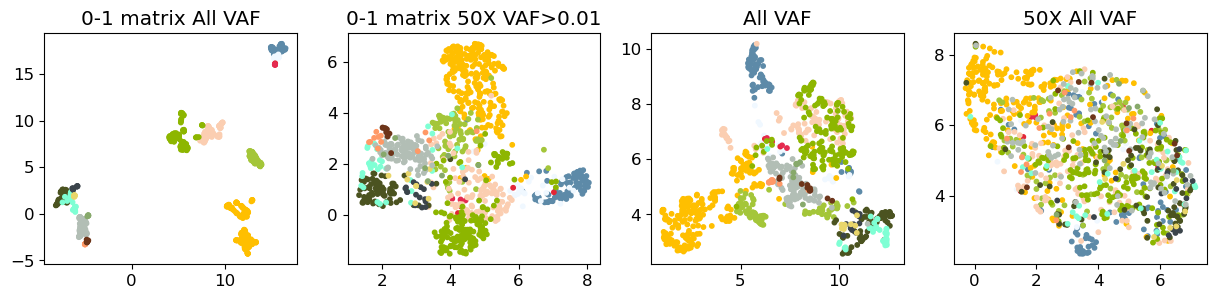

In [749]:
fig, ax = plt.subplots(1, 4, figsize=(15,3))
with open(f'{path}/mt_allmuts_30_0.phy', 'r') as f:
    seqs = f.readlines()
seqs = seqs[1:]
translation_table = str.maketrans({'A': '1', 'G': '0'})
muttab = []
cell_names = []
for i in seqs:
    muttab.append(list(i.translate(translation_table).split(' ')[1].strip()))
    cell_names.append(i.split(' ')[0])
mutdf = pd.DataFrame(np.array(muttab).astype(int), index=cell_names)
mut_umap = umap.UMAP(n_components=2).fit_transform(mutdf)
scat_color = []
for i in mutdf.index:
    scat_color.append(color_dict[i])
ax[0].scatter(mut_umap[:,0], mut_umap[:,1], s=10,c=scat_color)
ax[0].set_title('0-1 matrix All VAF')


with open(f'{path}/mt_allmuts_30_0.01_seq.phy', 'r') as f:
    seqs = f.readlines()
seqs = seqs[1:]
translation_table = str.maketrans({'A': '1', 'G': '0'})
muttab = []
cell_names = []
for i in seqs:
    muttab.append(list(i.translate(translation_table).split(' ')[1].strip()))
    cell_names.append(i.split(' ')[0])
mutdf = pd.DataFrame(np.array(muttab).astype(int), index=cell_names)

mut_umap = umap.UMAP(n_components=2).fit_transform(mutdf)
scat_color = []
for i in mutdf.index:
    scat_color.append(color_dict[i])
ax[1].scatter(mut_umap[:,0], mut_umap[:,1], s=10,c=scat_color)
ax[1].set_title('0-1 matrix 50X VAF>0.01')

scat_color = []
mut_umap = umap.UMAP(n_components=2).fit_transform(freq_30)
for i in mutdf.index:
    scat_color.append(color_dict[i])
ax[2].scatter(mut_umap[:,0], mut_umap[:,1], s=10,c=scat_color)
ax[2].set_title('All VAF')

scat_color = []
mut_umap = umap.UMAP(n_components=2).fit_transform(freq_30_seq)
for i in mutdf.index:
    scat_color.append(color_dict[i])
ax[3].scatter(mut_umap[:,0], mut_umap[:,1], s=10,c=scat_color)
ax[3].set_title('50X All VAF')

Text(0.5, 1.0, 'VAF-50X')

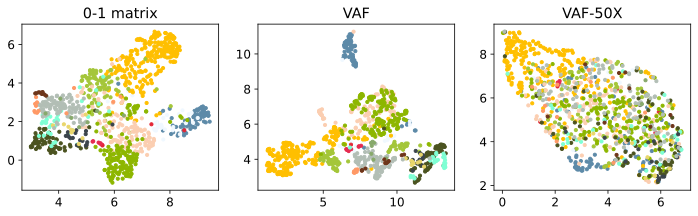

In [742]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
with open(f'{path}/mt_allmuts_30_0.01_seq.phy', 'r') as f:
    seqs = f.readlines()
seqs = seqs[1:]
translation_table = str.maketrans({'A': '1', 'G': '0'})
muttab = []
cell_names = []
for i in seqs:
    muttab.append(list(i.translate(translation_table).split(' ')[1].strip()))
    cell_names.append(i.split(' ')[0])
mutdf = pd.DataFrame(np.array(muttab).astype(int), index=cell_names)
mut_umap = umap.UMAP(n_components=2).fit_transform(mutdf)
scat_color = []
for i in mutdf.index:
    scat_color.append(color_dict[i])
ax[0].scatter(mut_umap[:,0], mut_umap[:,1], s=10,c=scat_color)
ax[0].set_title('0-1 matrix')

scat_color = []
X_pc100 = PCA(n_components=50).fit_transform(freq_30)
mut_umap = umap.UMAP(n_components=2).fit_transform(X_pc100)
for i in mutdf.index:
    scat_color.append(color_dict[i])
ax[1].scatter(mut_umap[:,0], mut_umap[:,1], s=10,c=scat_color)
ax[1].set_title('VAF')

scat_color = []
X_pc100 = PCA(n_components=50).fit_transform(freq_30_seq)
mut_umap = umap.UMAP(n_components=2).fit_transform(X_pc100)
for i in mutdf.index:
    scat_color.append(color_dict[i])
ax[2].scatter(mut_umap[:,0], mut_umap[:,1], s=10,c=scat_color)
ax[2].set_title('VAF-50X')